In [25]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.font_manager import FontProperties
from sklearn import manifold
from sklearn.cluster import KMeans
from sqlalchemy import create_engine
from sqlalchemy.ext.automap import automap_base

plt.rcParams['axes.unicode_minus']=False
%matplotlib inline

In [2]:
conn = sqlite3.connect('tw50.db')

In [3]:
c = conn.cursor()

In [4]:
cursor = c.execute("SELECT price,date FROM price WHERE id = ? ORDER BY date ASC",["0050 元大台灣50"])
rate0050 = []
rate0050.append(0.0)
x = []
temp = []
for row in cursor:
    temp.append(row[0])
    x.append(row[1])
    
for i in range(len(temp)):
    if i == 0:
        continue
    rate0050.append((temp[i]-temp[i-1])/temp[i-1])

In [5]:
for i,row in enumerate(x):
    row = row.split('-')
    print (row)
    x[i] = row[1]+row[2]
    print(x[i])

['2006', '01', '06']
0106
['2006', '01', '13']
0113
['2006', '01', '20']
0120
['2006', '01', '25']
0125
['2006', '02', '03']
0203
['2006', '02', '10']
0210
['2006', '02', '17']
0217
['2006', '02', '24']
0224
['2006', '03', '03']
0303
['2006', '03', '10']
0310
['2006', '03', '17']
0317
['2006', '03', '24']
0324
['2006', '03', '31']
0331
['2006', '04', '07']
0407
['2006', '04', '14']
0414
['2006', '04', '21']
0421
['2006', '04', '28']
0428
['2006', '05', '05']
0505
['2006', '05', '12']
0512
['2006', '05', '19']
0519
['2006', '05', '26']
0526
['2006', '06', '02']
0602
['2006', '06', '09']
0609
['2006', '06', '16']
0616
['2006', '06', '23']
0623
['2006', '06', '30']
0630
['2006', '07', '07']
0707
['2006', '07', '14']
0714
['2006', '07', '21']
0721
['2006', '07', '28']
0728
['2006', '08', '04']
0804
['2006', '08', '11']
0811
['2006', '08', '18']
0818
['2006', '08', '25']
0825
['2006', '09', '01']
0901
['2006', '09', '08']
0908
['2006', '09', '15']
0915
['2006', '09', '22']
0922
['2006', '09

In [6]:
len(x)

309

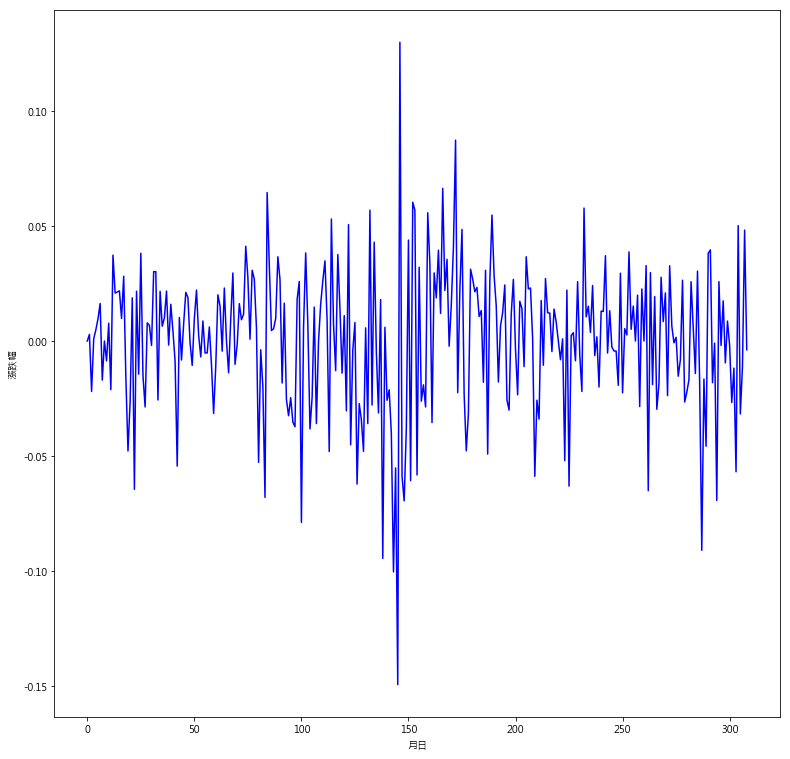

In [28]:
plt.figure(figsize=(13, 13))
plt.xlabel('月日')
plt.ylabel('漲跌幅')
plt.plot(rate0050,'b')
plt.show()

In [29]:
days_df = pd.DataFrame(
    {"day": x,
     "漲跌幅": rate0050
    }
)

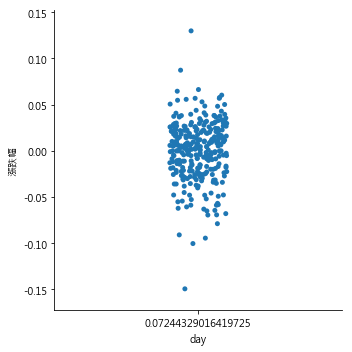

In [31]:
sns.catplot(data = days_df, x="day", y="漲跌幅", ci = None)

In [103]:
names = []

cursor = c.execute("SELECT DISTINCT id FROM price")
for row in cursor:
    names.append(row[0])

names.remove('0050 元大台灣50')
names.remove('5871 中租-KY')
names.remove('5880 合庫金')
# names.remove('2412 中華電')
# names.remove('4938 和碩')

In [104]:
len(names)

45

In [105]:
date = ['2008-01-04','2008-02-01','2008-03-07','2008-04-03','2008-05-02','2008-06-06','2008-07-04','2008-08-01',
        '2008-09-05','2008-10-03','2008-11-07','2008-12-05']

In [106]:
rate = []
for name in names:
    cursor = c.execute("SELECT price FROM price WHERE id = ?  AND date >= ? ORDER BY date ASC LIMIT 53",[name,'2010-12-03'])

    price = []
    for row in cursor:
        price.append(row[0])
    
    temp = []
    for i in range(len(price)):
        if i == 0:
            continue
        temp.append((price[i]-price[i-1])/price[i-1])
    rate.append(temp)

In [107]:
for i in range(len(rate)):
    if len(rate[i]) !=52:
        print(names[i])

In [108]:
distance = []
for i in rate:
    temp = []
    for j in rate:
        corr= np.corrcoef(i,j)
        corr = corr[0][-1]
        if i == j:
            corr = 1
        temp.append(1-(corr*0.5+0.5))
    distance.append(temp)

In [109]:
mds = manifold.MDS(n_jobs=3,random_state=1,dissimilarity="precomputed")
pos = mds.fit(distance).embedding_

clf = KMeans(n_clusters=4)
clf.fit(rate)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

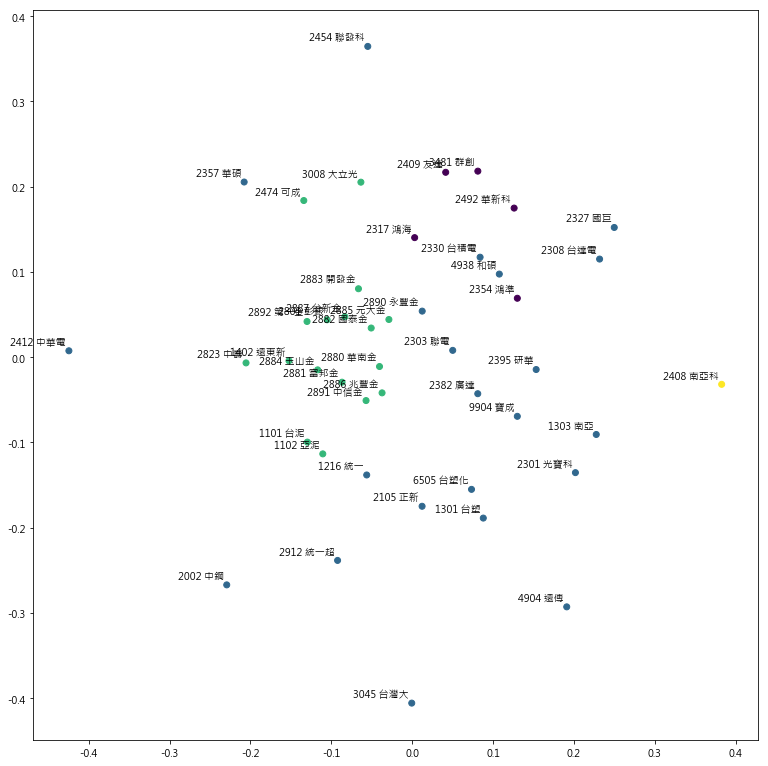

In [110]:
plt.figure(figsize=(13, 13))
plt.subplots_adjust(bottom=0.1)  
plt.scatter(pos[:, 0], pos[:, 1], c=clf.labels_)
for label, x, y in zip(names, pos[:, 0], pos[:, 1]):  
    plt.annotate(
        label,
        xy=(x, y), xytext=(-3, 3),
        textcoords='offset points', ha='right', va='bottom')
plt.show()

In [111]:
clf.labels_

array([2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 3, 0, 1, 1,
       2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 0, 1, 1, 1,
       1], dtype=int32)

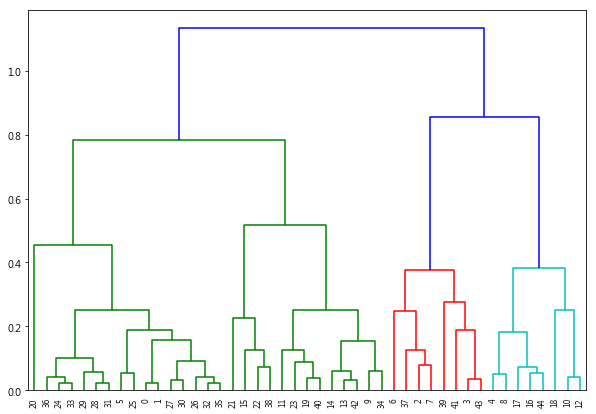

In [112]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))   
dend = shc.dendrogram(shc.linkage(pos, method='ward'))  

In [113]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  
cluster.fit_predict(pos)  

array([1, 1, 2, 2, 3, 1, 2, 2, 3, 0, 3, 0, 3, 0, 0, 0, 3, 3, 3, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 0, 2, 0, 2, 0, 2,
       3])

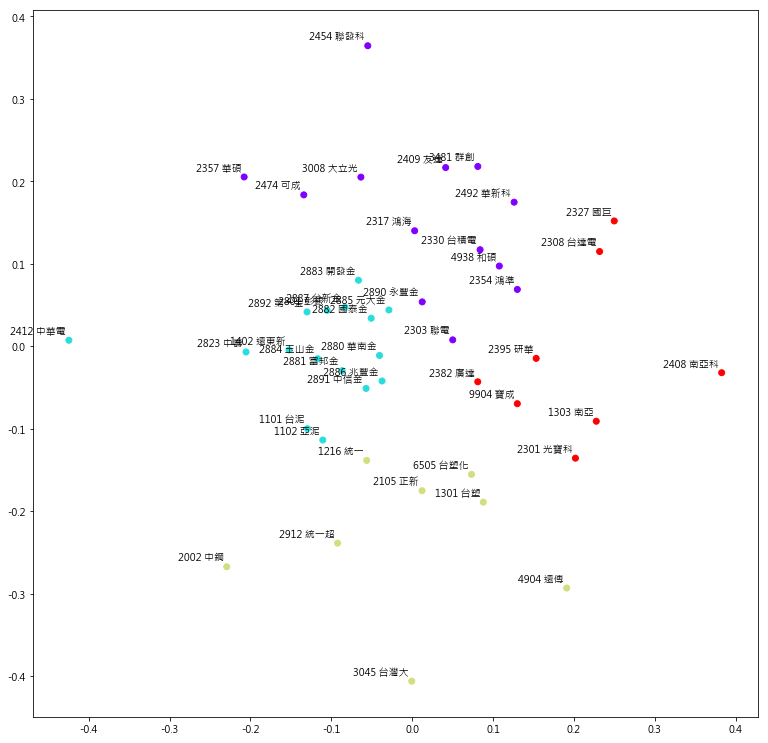

In [114]:
plt.figure(figsize=(13, 13))
plt.scatter(pos[:,0], pos[:,1], c=cluster.labels_, cmap='rainbow')
for label, x, y in zip(names, pos[:, 0], pos[:, 1]):  
    plt.annotate(
        label,
        xy=(x, y), xytext=(-3, 3),
        textcoords='offset points', ha='right', va='bottom')
plt.show()

In [43]:
for i in range(len(clf.labels_)):
    if clf.labels_[i] != clf.labels_[0]:
        print (names[i])

1301 台塑
1303 南亞
1402 遠東新
2002 中鋼
2105 正新
2301 光寶科
2303 聯電
2308 台達電
2317 鴻海
2327 國巨
2330 台積電
2354 鴻準
2357 華碩
2382 廣達
2395 研華
2408 南亞科
2409 友達
2454 聯發科
2474 可成
2492 華新科
2801 彰銀
2823 中壽
2880 華南金
2881 富邦金
2882 國泰金
2883 開發金
2884 玉山金
2885 元大金
2886 兆豐金
2887 台新金
2890 永豐金
2891 中信金
2892 第一金
3008 大立光
3481 群創
6505 台塑化
9904 寶成


In [44]:
num = []

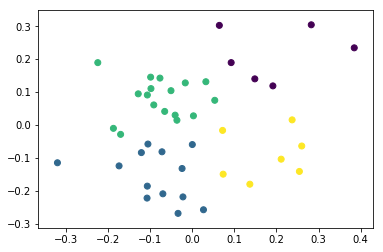

[0 0 0 3 3 2 1 3 2 3 1 1 2 1 1 1 3 1 2 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 0
 1 0 1 0 3 3]


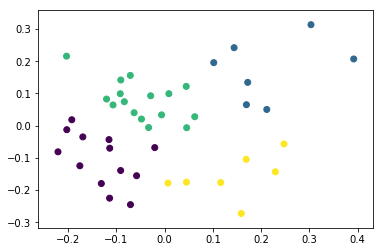

[1 1 1 3 3 2 3 1 2 3 0 0 0 3 0 0 3 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 1
 0 1 0 1 3 2]


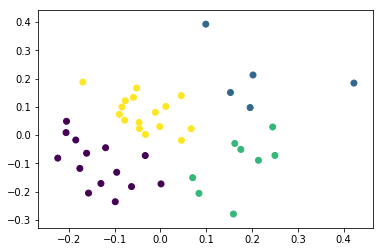

[2 2 1 2 2 3 2 1 3 2 0 0 0 0 0 0 2 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 1
 0 1 0 1 2 3]


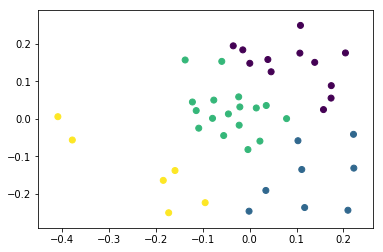

[3 3 3 1 1 2 1 3 1 2 0 0 0 0 0 0 1 2 2 0 0 0 0 2 1 2 2 2 2 2 2 2 2 2 2 2 1
 0 3 0 3 1 2]


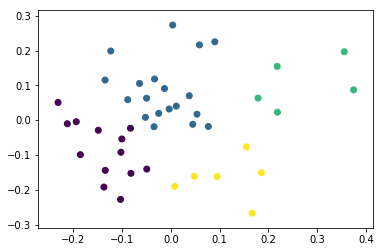

[2 2 2 3 3 1 3 1 1 3 0 0 0 3 0 0 3 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 2 0 2 1 1]


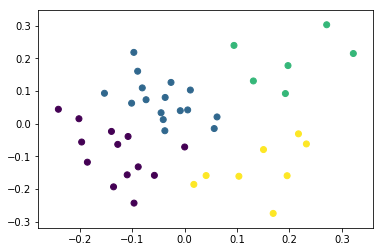

[2 2 2 3 3 1 3 2 1 3 0 0 0 3 0 0 3 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 3
 0 2 0 2 3 1]


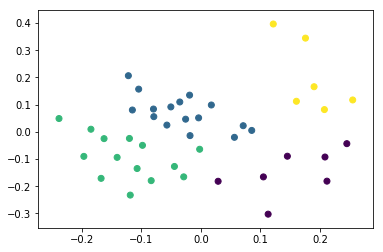

[3 3 3 0 0 1 0 3 1 0 2 2 2 2 2 2 0 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 2 3 2 3 0 1]


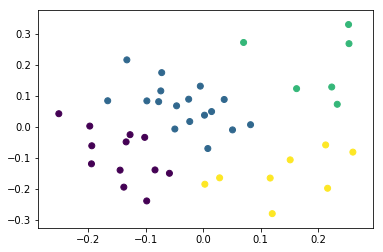

[2 2 2 3 3 1 3 2 1 3 0 0 0 3 0 0 3 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 3
 0 2 0 2 3 1]


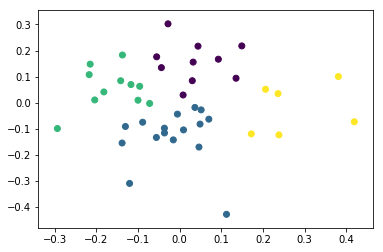

[3 3 3 2 0 1 0 0 0 0 0 2 2 0 2 2 0 0 1 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 2 3 2 3 3 0]


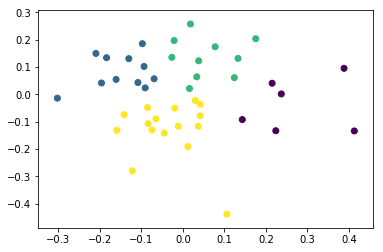

[0 0 0 1 2 3 2 2 2 2 2 1 1 2 1 1 2 2 3 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 1 0 1 0 0 2]


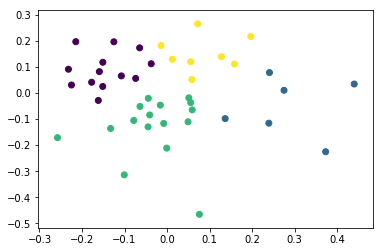

[1 1 1 2 3 0 0 3 3 3 0 0 0 3 0 0 3 3 2 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 0 1 0 1 1 3]


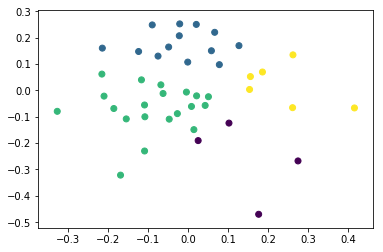

[2 0 2 2 2 2 1 3 3 1 1 1 1 3 1 1 3 3 0 1 1 1 1 2 2 2 2 2 2 2 2 2 0 2 2 2 2
 1 0 1 3 2 2]


In [19]:
for day in date:
    rate = []
    for name in names:
        cursor = c.execute("SELECT price FROM price WHERE id = ?  AND date >= ? ORDER BY date ASC LIMIT 53",[name,day])

        price = []
        for row in cursor:
            price.append(row[0])

        temp = []
        for i in range(len(price)):
            if i == 0:
                continue
            temp.append((price[i]-price[i-1])/price[i-1])
        rate.append(temp)
        
    distance = []
    for i in rate:
        temp = []
        for j in rate:
            corr= np.corrcoef(i,j)
            corr = corr[0][-1]
            if i == j:
                corr = 1
            temp.append(1-(corr*0.5+0.5))
        distance.append(temp)
        
    mds = manifold.MDS(n_jobs=3,random_state=1,dissimilarity="precomputed")
    pos = mds.fit(distance).embedding_

    clf = KMeans(n_clusters=4)
    clf.fit(pos)
    plt.scatter(pos[:, 0], pos[:, 1], c=clf.labels_)
    plt.show()
    print(clf.labels_)
    
    for i in range(len(clf.labels_)):
        if clf.labels_[i] == clf.labels_[-3]:
            num.append(i)

In [20]:
num = list(set(num))

In [21]:
print (num)

[0, 1, 2, 36, 38, 7, 40, 41, 8, 13, 16, 17]


In [22]:
for i in range(len(names)):
    if i not in num:
        print(names[i])

1301 台塑
1303 南亞
1402 遠東新
2002 中鋼
2303 聯電
2308 台達電
2317 鴻海
2327 國巨
2354 鴻準
2357 華碩
2408 南亞科
2409 友達
2454 聯發科
2474 可成
2492 華新科
2801 彰銀
2823 中壽
2880 華南金
2881 富邦金
2882 國泰金
2883 開發金
2884 玉山金
2885 元大金
2886 兆豐金
2887 台新金
2890 永豐金
2891 中信金
2892 第一金
3008 大立光
3481 群創
9904 寶成


In [23]:
print (names[-3])

4904 遠傳


In [24]:
total_distance = np.zeros([43,43])

In [25]:
for day in date:
    rate = []
    for name in names:
        cursor = c.execute("SELECT price FROM price WHERE id = ?  AND date >= ? ORDER BY date ASC LIMIT 53",[name,day])

        price = []
        for row in cursor:
            price.append(row[0])

        temp = []
        for i in range(len(price)):
            if i == 0:
                continue
            temp.append((price[i]-price[i-1])/price[i-1])
        rate.append(temp)
        
    distance = []
    for i in rate:
        temp = []
        for j in rate:
            corr= np.corrcoef(i,j)
            corr = corr[0][-1]
            if i == j:
                corr = 1
            temp.append(1-(corr*0.5+0.5))
        distance.append(temp)
        
    total_distance += np.asarray(distance)

In [26]:
sr = np.argsort(total_distance)

In [27]:
for i in sr:
    print(i)

[ 0  1 29 31 23  2 42  5 24 16  9  7 41 28 26 13  4  6 17 25 14 33 22 19
 32 34  8 39 27 11 10 35 30 12 38 36 40  3 15 18 37 20 21]
[ 1  0  5 31 42 29 23  2 34 28 19  7 17 30  9 39  8 24  4 26 14 25 27 33
 35 16 22 11 12 32 13 15 10 41 36 18  6 40 21  3 20 37 38]
[ 2  0  1 42 31 28 23  4 27 24  5 30  7 34 29 26 36 41 32 25 35 33  9  3
  6 17 10 40 22 16  8 38 14 12 11 13 19 39 15 18 37 21 20]
[ 3  4 41 25 42 23  5 31 16  9 35 33 30 22 36 27 28 20 13 17 26 21 37 11
 24 14 15  2  6 10 32  7 29  8 34 12  0 19 39  1 38 18 40]
[ 4  3 41 42 23 28  7  5 13 31 16 17  9 30 25 22 33 26 10  2 15 37  0 27
  1 29 19 20 21 24 35 14 12 34  8 36 39  6 32 11 38 18 40]
[ 5 33 27 34 30 42 35 14 24 28  1 25 23 26 29 39 31 22 32 21 11  4 19 15
  9 10 17  0 36 12  7 16 20  2 41  3  8 37 13 18  6 40 38]
[ 6 13  9 11 31 19  0 29 17 37 25 27 10 15 23  4 14 28 20 16 26 35  5  2
 33  3 30 34 32 39 24 41  1 22  8 42  7 12 21 36 40 38 18]
[ 7  4 23  1 42 17  0  9  5 28 10  2 41 22 16 14 25 13 33 30 26 21 31 12
 20

In [28]:
for i in range(len(names)):
    print(names[i] + '   ' + names[sr[i][-1]] + '   ' + names[sr[i][-2]] + '   ' + names[sr[i][-3]])

1101 台泥   2474 可成   2454 聯發科   3008 大立光
1102 亞泥   3045 台灣大   3008 大立光   2454 聯發科
1216 統一   2454 聯發科   2474 可成   3008 大立光
1301 台塑   4904 遠傳   2408 南亞科   3045 台灣大
1303 南亞   4904 遠傳   2408 南亞科   3045 台灣大
1402 遠東新   3045 台灣大   4904 遠傳   2002 中鋼
2002 中鋼   2408 南亞科   3045 台灣大   4904 遠傳
2105 正新   3045 台灣大   4904 遠傳   2408 南亞科
2301 光寶科   3045 台灣大   4904 遠傳   6505 台塑化
2303 聯電   3045 台灣大   4904 遠傳   2912 統一超
2308 台達電   3045 台灣大   4904 遠傳   2912 統一超
2317 鴻海   3045 台灣大   4904 遠傳   2912 統一超
2327 國巨   3045 台灣大   4904 遠傳   2912 統一超
2330 台積電   4904 遠傳   3045 台灣大   1216 統一
2354 鴻準   4904 遠傳   3045 台灣大   1216 統一
2357 華碩   3045 台灣大   4904 遠傳   1216 統一
2382 廣達   4904 遠傳   3045 台灣大   2408 南亞科
2395 研華   3045 台灣大   4904 遠傳   1216 統一
2408 南亞科   4904 遠傳   1301 台塑   3045 台灣大
2409 友達   3045 台灣大   4904 遠傳   1216 統一
2454 聯發科   3045 台灣大   4904 遠傳   1216 統一
2474 可成   4904 遠傳   3045 台灣大   1216 統一
2492 華新科   4904 遠傳   3045 台灣大   2912 統一超
2801 彰銀   3045 台灣大   4904 遠傳   2002 中鋼
2823 中壽   3045 台灣大   4904 遠傳   2002 中鋼
288

In [29]:
cursor = c.execute("SELECT date FROM price WHERE id = '2408 南亞科'  AND date >= '2008-12-05' ORDER BY date ASC LIMIT 53")
for row in cursor:
    print(row)

('2008-12-05',)
('2008-12-12',)
('2008-12-19',)
('2008-12-26',)
('2008-12-31',)
('2009-01-10',)
('2009-01-17',)
('2009-01-21',)
('2009-02-06',)
('2009-02-13',)
('2009-02-20',)
('2009-02-27',)
('2009-03-06',)
('2009-03-13',)
('2009-03-20',)
('2009-03-27',)
('2009-04-03',)
('2009-04-10',)
('2009-04-17',)
('2009-04-24',)
('2009-04-30',)
('2009-05-08',)
('2009-05-15',)
('2009-05-22',)
('2009-05-27',)
('2009-06-06',)
('2009-06-12',)
('2009-06-19',)
('2009-06-26',)
('2009-07-03',)
('2009-07-10',)
('2009-07-17',)
('2009-07-24',)
('2009-07-31',)
('2009-08-06',)
('2009-08-14',)
('2009-08-28',)
('2009-09-04',)
('2009-09-11',)
('2009-09-18',)
('2009-09-25',)
('2009-10-02',)
('2009-10-09',)
('2009-10-16',)
('2009-10-23',)
('2009-10-30',)
('2009-11-06',)
('2009-11-13',)
('2009-11-20',)
('2009-11-27',)
('2009-12-04',)
('2009-12-11',)
('2009-12-18',)


In [30]:
rate = {}
for name in names:
    cursor = c.execute("SELECT price,id FROM price WHERE id = ?  AND (date = '2008-01-04' OR date = '2009-12-18') ORDER BY date ASC",[name])

    price = []
    for row in cursor:
        price.append(row[0])
        name = row[1]
    rate[name] = (price[1]-price[0])/price[0]

In [31]:
cursor = c.execute("SELECT price FROM price WHERE id = '0050 元大台灣50' AND (date = '2008-01-04' OR date = '2009-12-18') ORDER BY date ASC")
price = []
for row in cursor:
    price.append(row[0])
rate['0050 元大台灣50'] = (price[1]-price[0])/price[0]

In [32]:
print(rate)

{'1101 台泥': -0.27467811158798294, '1102 亞泥': -0.2927083333333333, '1216 統一': -0.13922651933701652, '1301 台塑': -0.2722222222222222, '1303 南亞': -0.32932692307692313, '1402 遠東新': -0.012722646310432571, '2002 中鋼': -0.2779700115340254, '2105 正新': 0.4217821782178217, '2301 光寶科': -0.15384615384615385, '2303 聯電': -0.18537859007832894, '2308 台達電': -0.06268656716417907, '2317 鴻海': -0.24043715846994534, '2327 國巨': -0.06018518518518522, '2330 台積電': 0.03166666666666664, '2354 鴻準': -0.5095541401273885, '2357 華碩': -0.4085239085239086, '2382 廣達': 0.5917431192660552, '2395 研華': 0.08583690987124463, '2408 南亞科': 0.282122905027933, '2409 友達': -0.3915254237288136, '2454 聯發科': 0.44141689373297005, '2474 可成': -0.47306501547987617, '2492 華新科': -0.3672566371681416, '2801 彰銀': -0.17597765363128484, '2823 中壽': 0.24, '2880 華南金': -0.09112149532710277, '2881 富邦金': 0.2665534804753819, '2882 國泰金': -0.1693430656934307, '2883 開發金': -0.27125506072874495, '2884 玉山金': -0.24404761904761912, '2885 元大金': 0.009501187648456023

In [33]:
remuneration = []
for i in range(len(names)):
    temp = rate[names[i]] + rate[names[sr[i][-1]]] + rate[names[sr[i][-2]]] + rate[names[sr[i][-3]]]
    remuneration.append(temp)

In [34]:
remuneration.append(-0.09898477157360408)

In [35]:
remuneration

[-0.2430350940943828,
 0.614745695063484,
 -0.10758350184341631,
 0.3447454436611504,
 0.2876407428064495,
 0.04415210301098166,
 0.33899765434934725,
 1.0387498441011944,
 0.06795512874841612,
 0.03569371568729031,
 0.15838573860144012,
 -0.0193648527043261,
 0.16088712058043397,
 0.22728490818508973,
 -0.3139358986089654,
 -0.2129056670054855,
 1.2087107851494279,
 0.28145515138966776,
 0.34474544366115045,
 -0.19590718221039052,
 0.6370351352513932,
 -0.2774467739614531,
 -0.14618433140252235,
 -0.11910290430987064,
 0.29687474932141417,
 -0.03424674600568858,
 0.32342822979679614,
 0.5872838733798307,
 -0.21438031140733074,
 -0.18142508041440172,
 0.06637593696987026,
 0.6762616545884097,
 0.6200955737596081,
 -0.007902578613808331,
 -0.12272228895298953,
 0.5582970852110484,
 -0.056897705768406165,
 0.2589093807589294,
 -0.9971566239286448,
 -0.33969393862487274,
 -1.012987290950567,
 -0.05266796164699172,
 -0.092785114624164,
 -0.09898477157360408]

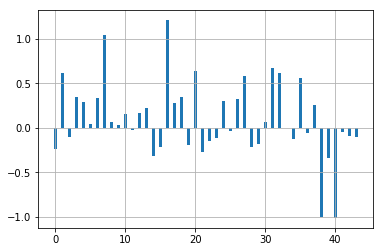

In [36]:
index = np.arange(len(remuneration))
k = plt.bar(index,remuneration, .5)
plt.grid(True)
plt.show()

In [37]:
for i in range(len(names)):
    print(str(i) + '   ' + names[i] + '   ' + names[sr[i][-1]] + '   ' + names[sr[i][-2]] + '   ' + names[sr[i][-3]]+ '   ' + str(remuneration[i]))

0   1101 台泥   2474 可成   2454 聯發科   3008 大立光   -0.2430350940943828
1   1102 亞泥   3045 台灣大   3008 大立光   2454 聯發科   0.614745695063484
2   1216 統一   2454 聯發科   2474 可成   3008 大立光   -0.10758350184341631
3   1301 台塑   4904 遠傳   2408 南亞科   3045 台灣大   0.3447454436611504
4   1303 南亞   4904 遠傳   2408 南亞科   3045 台灣大   0.2876407428064495
5   1402 遠東新   3045 台灣大   4904 遠傳   2002 中鋼   0.04415210301098166
6   2002 中鋼   2408 南亞科   3045 台灣大   4904 遠傳   0.33899765434934725
7   2105 正新   3045 台灣大   4904 遠傳   2408 南亞科   1.0387498441011944
8   2301 光寶科   3045 台灣大   4904 遠傳   6505 台塑化   0.06795512874841612
9   2303 聯電   3045 台灣大   4904 遠傳   2912 統一超   0.03569371568729031
10   2308 台達電   3045 台灣大   4904 遠傳   2912 統一超   0.15838573860144012
11   2317 鴻海   3045 台灣大   4904 遠傳   2912 統一超   -0.0193648527043261
12   2327 國巨   3045 台灣大   4904 遠傳   2912 統一超   0.16088712058043397
13   2330 台積電   4904 遠傳   3045 台灣大   1216 統一   0.22728490818508973
14   2354 鴻準   4904 遠傳   3045 台灣大   1216 統一   -0.3139358986089654
15   23

In [38]:
rate = []

In [39]:
cursor = c.execute("SELECT price_adjustment FROM price WHERE id = '0050 元大台灣50' AND (date = '2006-01-06' OR date = '2011-12-30') ORDER BY date ASC")
price = []
for row in cursor:
    price.append(row[0])
rate = (price[1]-price[0])/price[0]

In [40]:
rate

0.2367629362214199

In [41]:
rate/6*100

3.9460489370236647

In [42]:
earn = []
earn.append(names[16])
earn.append(names[sr[16][-1]])
earn.append(names[sr[16][-2]])
# earn.append(names[sr[16][-3]])
earn

['2382 廣達', '4904 遠傳', '3045 台灣大']

In [43]:
rate = []

In [44]:
for name in earn:
    cursor = c.execute("SELECT price_adjustment FROM price WHERE id = ? AND (date = '2006-01-06' OR date = '2011-12-30') ORDER BY date ASC",[name])
    price = []
    for row in cursor:
        price.append(row[0])
    rate.append((price[1]-price[0])/price[0])

In [45]:
rate

[1.0239549084077033, 0.9428982725527832, 2.5828321487151453]

In [46]:
final = 0
for i in rate:
    final += i/4

In [47]:
final

1.137421332418908

In [48]:
final/6*100

18.9570222069818

In [49]:
final/rate

TypeError: unsupported operand type(s) for /: 'float' and 'list'

In [45]:
from matplotlib.font_manager import findfont, FontProperties  
findfont(FontProperties(family=FontProperties().get_family()))

'/home/xiangli/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/msj.ttf'